In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mean_confidence_interval(data, confidence=0.95):
    # Calculate confidence interval for sample mean
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m,3), round(m-h,3), round(m+h,3)

In [3]:
def ttestab(a,b):
    # Summarize the groups  
    confident_a = mean_confidence_interval(a, confidence=0.95)
    confident_b = mean_confidence_interval(b, confidence=0.95)
    result = [{'Group':'A','Sample size':len(a),'Mean':confident_a[0],
               'Stdev': round(a.std(),3),'95% CI of Mean':confident_a[1:]},
              {'Group':'B','Sample size':len(b),'Mean':confident_b[0],
               'Stdev': round(b.std(),3),'95% CI of Mean':confident_b[1:]}]
    print(pd.DataFrame(result))
    print("\n")
    
    # Running 2 sampled t test comparing means
    cm = sms.CompareMeans(sms.DescrStatsW(b), sms.DescrStatsW(a))
    dm = cm.tconfint_diff(alpha=0.05,usevar='unequal')
    print(cm.summary())
    print ("Difference between 2 means: ", round(b.mean()-a.mean(),3), "+/-", round(cm.std_meandiff_separatevar,3))
    print("95% CI of difference between means: ", dm)
    print("95% CI of difference between means: [", round(100*dm[0]/confident_a[0], 3), "%, ", round(100*dm[1]/confident_a[0], 3), "% ]")
    
    return cm

In [4]:
def plotSamplingMean(numofsample,samplesize,population,label):
    # collect mean of each sample
    eachMeanSample = []
    # for each sampling
    for j in range(0,numofsample):
        # sampling 'samplesize' sample from population
        rc = random.choices(list(population), k=samplesize)
        # collect mean of each sample
        eachMeanSample.append(sum(rc)/len(rc))
    f=plt.hist(eachMeanSample,bins=30,alpha=0.5,label=label)
    plt.legend(loc='best')
    plt.xlabel('Mean of metric')

In [5]:
def testing_by_dayinterval_sum_metric(df_test,metric,day_window=1,exp_id='1',group_id='1'):
    df_days = df_test[df_test['day0_date']<=df_test['act_date'].max()-timedelta(days=day_window-1)]
    print("Max day0: ", df_days['day0_date'].max())
    print("Min day0: ", df_days['day0_date'].min())
    df_days = df_days[df_days['day_diff']<day_window].groupby(['resettable_device_id_or_app_instance_id','experiment_group'])[metric].sum().reset_index()
    a = df_days[df_days['experiment_group']=='firebase_exp_{}_group{}'.format(exp_id, '0')][metric]
    b = df_days[df_days['experiment_group']=='firebase_exp_{}_group{}'.format(exp_id, group_id)][metric]
    ttestab(a,b)
    return df_days,a,b

In [6]:
def testing_by_dayinterval_max_metric(df_test,metric,day_window=1,exp_id='1',group_id='1'):
    df_days = df_test[df_test['day0_date']<=df_test['act_date'].max()-timedelta(days=day_window-1)]
    print("Max day0: ", df_days['day0_date'].max())
    print("Min day0: ", df_days['day0_date'].min())
    df_days = df_days[df_days['day_diff']<day_window].groupby(['resettable_device_id_or_app_instance_id','experiment_group'])[metric].max().reset_index()
    a = df_days[df_days['experiment_group']=='firebase_exp_{}_group{}'.format(exp_id, '0')][metric]
    b = df_days[df_days['experiment_group']=='firebase_exp_{}_group{}'.format(exp_id, group_id)][metric]
    ttestab(a,b)
    return df_days,a,b

In [7]:
def compare_mean_metric(df_test, metrics, confidence=0.95, day_window=1,exp_id='1',group_id='1'):
    print("Compare 95% CI of Mean:")
    for m in metrics:
        df_days = df_test[df_test['day0_date']<=df_test['act_date'].max()-timedelta(days=day_window-1)]
        df_days = df_days[df_days['day_diff']<day_window].groupby(['resettable_device_id_or_app_instance_id','experiment_group'])[m].sum().reset_index()
        a = df_days[df_days['experiment_group']=='firebase_exp_{}_group{}'.format(exp_id, '0')][m]
        b = df_days[df_days['experiment_group']=='firebase_exp_{}_group{}'.format(exp_id, group_id)][m]
        
        confident_a = mean_confidence_interval(a, confidence)
        confident_b = mean_confidence_interval(b, confidence)
        
        diff = confident_b[1:]/confident_a[0] - 1
        
        print(m, ": [", round(100*diff[0],3), "%, ", round(100*diff[1],3), "%]")

In [26]:
#df = pd.read_excel("Sui_20210110- 20210120.xlsx", sheet_name='Sui_20210110- 20210120')
df = pd.read_csv('ACi-3.csv')
df.drop(columns=['platform','device_model'],inplace=True)
#df['country'].value_counts()
# Clean up data
df_test = df[~df['experiment_group'].isna()]
# Exclude 1 data point of Japan
df_test = df_test[df_test['country']=='United States']
df_test=df_test[df_test['day_diff']>=0]
df_test.to_csv("ACi-3-Cleaned.csv",index=False)

In [9]:
# Metric for test: rv_imp * 1.3 + is_imp

In [10]:
df_test['country'].value_counts()

United States          4870
Japan                  1341
United Kingdom          642
Taiwan                  403
Russia                  255
                       ... 
Morocco                   1
Madagascar                1
Bangladesh                1
Congo - Brazzaville       1
Kosovo                    1
Name: country, Length: 89, dtype: int64

In [27]:
df_test = pd.read_csv("ACi-3-Cleaned.csv")
df_test['act_date'] = pd.to_datetime(df_test['act_date'])
df_test['day0_date'] = pd.to_datetime(df_test['day0_date'])

In [28]:
# Count unique users in each group
#df_test.groupby('experiment_group')['resettable_device_id_or_app_instance_id'].nunique()
df_test.groupby('day0_date')['resettable_device_id_or_app_instance_id'].nunique()

day0_date
2021-01-15      14
2021-01-16      27
2021-01-17      28
2021-01-18      70
2021-01-19      42
2021-01-20     612
2021-01-21     885
2021-01-22     932
2021-01-23    1035
2021-01-24    1071
2021-01-25     790
2021-01-26     756
2021-01-27     991
2021-01-28     981
2021-01-29     172
2021-01-30      15
2021-01-31       1
Name: resettable_device_id_or_app_instance_id, dtype: int64

In [33]:
# Calculating metric
df_test['combined_metric'] = df_test['rv_imp_sum']*1.3 + df_test['is_imp_sum']
#df_test['combined_metric'] = df_test['rv_Revive_Revive'] + df_test['rv_LiveRequest_LiveInRequestHome']
#df_test['combined_metric'] = df_test['rv_Game_X2Dame']
#df_test['combined_metric'] = df_test['rv_Game_X2Health']
#df_test['combined_metric'] = df_test['max_stage']
#df_test['combined_metric'] = df_test['rv_Revive_Revive'] + df_test['rv_LiveRequest_LiveInRequestHome']
#df_test['combined_metric'] = df_test['buy_skin_7'] + df_test['buy_skin_8'] + df_test['buy_skin_9'] + df_test['buy_skin_10'] + df_test['buy_skin_11'] + df_test['buy_skin_12'] + df_test['buy_skin_13'] + df_test['buy_skin_14'] + df_test['buy_skin_15'] + df_test['buy_skin_16']+ df_test['buy_skin_17'] + df_test['buy_skin_18'] + df_test['buy_skin_19']+ df_test['buy_skin_22'] + df_test['buy_skin_23'] + df_test['buy_skin_24']+ df_test['buy_skin_25']

In [30]:
df_test.columns
#df_test.columns[50:100]
#metric = ['buy_skin_22', 'buy_skin_23', 'buy_skin_24', 'buy_skin_25', 'buy_skin_7', 'buy_skin_8', 'buy_skin_9', 'buy_skin_10', 'buy_skin_11', 'buy_skin_12', 'buy_skin_13', 'buy_skin_14', 'buy_skin_15', 'buy_skin_16', 'buy_skin_17', 'buy_skin_18', 'buy_skin_19']
#df_group1 = df_test[df_test['experiment_group']=='firebase_exp_18_group1']

#for m in metric:
#    print('{}: {}\n'.format(m, df_group1[m].sum()))

Index(['resettable_device_id_or_app_instance_id', 'day0_date', 'country',
       'os_version', 'os_version_group', 'app_version', 'experiment_group',
       'media_source', 'user_type', 'user_count', 'act_date', 'day_diff',
       'dau', 'time_in_game_sum', 'rv_imp_sum', 'rv_click_sum', 'is_imp_sum',
       'is_click_sum', 'battle_end_sum', 'battle_play_sum',
       'rv_imp_LostScreen', 'rv_imp_WinScreen', 'rv_imp_daily_reward',
       'rv_imp_main_screen', 'rv_imp_new_reward_panel', 'rv_imp_shop',
       'rv_imp_skin_screen', 'rv_request_imp_LostScreen',
       'rv_request_imp_WinScreen', 'rv_request_imp_daily_reward',
       'rv_request_imp_main_screen', 'rv_request_imp_new_reward_panel',
       'rv_request_imp_shop', 'rv_request_imp_skin_screen', 'play_node_1_1',
       'play_node_1_2', 'play_node_1_3', 'play_node_2_1', 'play_node_2_2',
       'play_node_2_3', 'play_node_3_1', 'play_node_3_2', 'play_node_3_3',
       'play_node_4_1', 'play_node_5_1', 'end_node_1_1', 'end_node_1_2',


In [31]:
#df_group1['resettable_device_id_or_app_instance_id'].nunique()

### Run test on whole data

In [41]:
df_days,a,b = testing_by_dayinterval_sum_metric(df_test,'combined_metric',day_window=7,exp_id='3',group_id='1')

Max day0:  2021-01-29 00:00:00
Min day0:  2021-01-15 00:00:00
  Group  Sample size    Mean   Stdev    95% CI of Mean
0     A         4522  10.026  12.945   (9.649, 10.404)
1     B         3879  11.463  13.110  (11.051, 11.876)


                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      1.4370      0.285      5.043      0.000       0.878       1.996
Difference between 2 means:  1.437 +/- 0.285
95% CI of difference between means:  (0.8779052479988143, 1.996189296400946)
95% CI of difference between means: [ 8.756 %,  19.91 % ]


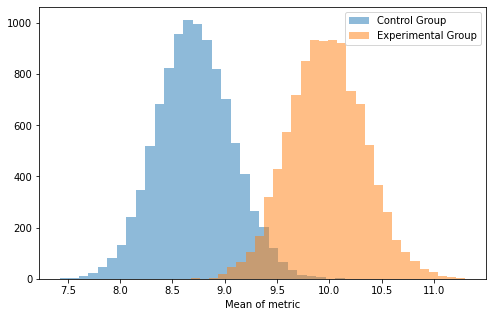

In [37]:
# Visualize the two population means
plt.figure(figsize=(8,5))
plotSamplingMean(10000,1000,a,'Control Group')
plotSamplingMean(10000,1000,b,'Experimental Group')

### Segment data and run test

In [40]:
col = 'day0_date'
groupby = df_test[col].value_counts().reset_index().sort_values('index')
groupby.columns = [col,'count']
col_values = list(groupby[groupby['count']>1000][col]) #Only run test when sample size > 1000
print(col_values)

for value in col_values:
    df_subset = df_test[df_test[col]==value]
    print("\n \n--------------------Segmented by:", col,"=", value,'--------------------')
    df_days,a,b = testing_by_dayinterval_sum_metric(df_subset,'combined_metric',day_window=3,exp_id='3',group_id='1')

[Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-23 00:00:00'), Timestamp('2021-01-24 00:00:00'), Timestamp('2021-01-25 00:00:00'), Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-27 00:00:00'), Timestamp('2021-01-28 00:00:00')]

 
--------------------Segmented by: day0_date = 2021-01-20 00:00:00 --------------------
Max day0:  2021-01-20 00:00:00
Min day0:  2021-01-20 00:00:00
  Group  Sample size   Mean   Stdev   95% CI of Mean
0     A          323  9.173  12.961  (7.754, 10.592)
1     B          289  9.097   9.302   (8.02, 10.174)


                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.0755      0.922     -0.082      0.935      -1.885       1.734
Difference between 2 means:  -0.076 +/- 0.905
95% CI of differen

In [ ]:
df_subset = df_test[df_test[col].isin(['2021-01-01','2021-01-02','2020-12-27','2020-12-28'])]
print("\nSegmented by:", col,"=", value)
df_days,a,b = testing_by_dayinterval(df_subset,day_window=1)

In [ ]:
metric = ['buy_skin_22', 'buy_skin_23', 'buy_skin_24', 'buy_skin_25', 'buy_skin_7', 'buy_skin_8', 'buy_skin_9', 'buy_skin_10', 'buy_skin_11', 'buy_skin_12', 'buy_skin_13', 'buy_skin_14', 'buy_skin_15', 'buy_skin_16', 'buy_skin_17', 'buy_skin_18', 'buy_skin_19']

for m in metric:
    print("\n \n--------------------AB Test Matric:", m,' --------------------')
    df_days,a,b = testing_by_dayinterval_sum_metric(df_test,m,day_window=3,exp_id='18',group_id='1')